In [1]:
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.core.Datasets import Datasets
from ptrail.preprocessing.statistics import Statistics

# Load the Starkey dataset.
starkey = Datasets.load_starkey()
starkey.head()

------------------------ Dataset Facts ------------------------------

Number of unique Trajectories in the data: 253
Number of points in the data: 287136
Dataset time range: 1196 days 22:51:45
Datatype of the DataFrame: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>
Dataset Bounding Box: (45.18896978643169, -118.61020848239596, 45.314545642992, -118.50455596234036)

---------------------------------------------------------------------


lat         lon  StarkeyTime    GMDate  \
traj_id   DateTime                                                            
880109D01 1995-04-13 13:40:06  45.239682 -118.533204    229902006  21:40:06   
          1995-04-15 12:16:15  45.250521 -118.530438    230069775  20:16:15   
          1995-04-15 21:39:38  45.247943 -118.541455    230103578  05:39:38   
          1995-04-16 03:32:14  45.247429 -118.539530    230124734  11:32:14   
          1995-04-16 04:08:28  45.247117 -118.542579    230126908  12:08:28   

                                 GMTime   LocDate   LocTime  RadNum  Species  \
traj_id   DateTime                                                             
880109D01 1995-04-13 13:40:06  19950413  19950413  13:40:06     409        0   
          1995-04-15 12:16:15  19950415  19950415  12:16:15     409        0   
          1995-04-15 21:39:38  19950416  19950415  21:39:38     409        0   
          1995-04-16 03:32:14  19950416  19950416  03:32:14     409        0   
          1995-04-16 04:08:28  19950416  19950416  04:08:28     409        0   

                                 UTME     UTMN  Year  Grensunr  Grensuns  \
traj_id   DateTime                                                         
880109D01 1995-04-13 13:40:06  379662  5010734    95  13:13:00  02:39:00   
          1995-04-15 12:16:15  379895  5011927    95  13:09:00  02:41:00   
          1995-04-15 21:39:38  379039  5011656    95  13:07:00  02:43:00   
          1995-04-16 03:32:14  379188  5011581    95  13:07:00  02:43:00   
          1995-04-16 04:08:28  378938  5011567    95  13:07:00  02:43:00   

                               Obswt  
traj_id   DateTime                    
880109D01 1995-04-13 13:40:06   1.47  
          1995-04-15 12:16:15   1.59  
          1995-04-15 21:39:38   1.34  
          1995-04-16 03:32:14   1.50  
          1995-04-16 04:08:28   1.34

In [2]:
%%time

"""
Our course of action

1. First, generate a set of spatial and temporal features on the
   dataset.
2. Then, based on the above generated features, clean the dataset
   to reduce noise as well as make the trajectories smoother.
3. Then, once the noise has been cleared, we will further make
   the trajectory smoother, we will interpolate the trajectories.
   Now, an important point to consider for interpolation is that
   only 4 fundamental columns are returned.
4. Then, train various models based on the original starkey dataset.
5. Based on that trained model, we will predict the species of the
   animal for the interpolated and cleaned dataset.
"""

# Step - 1: Feature generation.
# The following features are being generated:
#   1. Distance between consecutive points of the trajectory.
from ptrail.features.kinematic_features import KinematicFeatures
from ptrail.features.temporal_features import TemporalFeatures

starkey_feat = KinematicFeatures.create_distance_column(starkey)
starkey_feat = TemporalFeatures.create_time_of_day_column(starkey_feat)

CPU times: user 1.35 s, sys: 294 ms, total: 1.64 s
Wall time: 1.99 s


In [3]:
%%time

# Step - 2: Filtering.

# 2.1: Hampel filter based on distance between consecutive points.
from ptrail.preprocessing.filters import Filters

hamp_filt_starkey = Filters.hampel_outlier_detection(dataframe=starkey_feat,
                                                     column_name='Distance')
print(f"Length of original Dataframe: {len(starkey_feat)}")
print(f"Length of DataFrame after filtering: {len(hamp_filt_starkey)}")

/home/yjharanwala/Desktop/PTRAIL/ptrail/preprocessing/filters.py:726: UserWarning: If kinematic features have been generated on the dataframe, then make sure to generate them again as outlier detection drops the point from the dataframe and does not run the kinematic features again.
  warnings.warn("If kinematic features have been generated on the dataframe, then make "


Length of original Dataframe: 287136
Length of DataFrame after filtering: 262207
CPU times: user 830 ms, sys: 228 ms, total: 1.06 s
Wall time: 25.9 s


In [4]:
# 2.2: Remove duplicate points from the trajectories.

dupl_filt_starkey = Filters.remove_duplicates(dataframe=hamp_filt_starkey)
dupl_filt_starkey = dupl_filt_starkey.drop_duplicates(subset=['DateTime', 'traj_id'])
print(f"Length of original Dataframe: {len(hamp_filt_starkey)}")
print(f"Length of DataFrame after filtering: {len(dupl_filt_starkey)}")

Length of original Dataframe: 262207
Length of DataFrame after filtering: 262206


In [5]:
# 2.3 Remove trajectories with few points.

few_filt_starkey = Filters.remove_trajectories_with_less_points(dataframe=dupl_filt_starkey,
                                                                num_min_points=5)
print(f"Length of original Dataframe: {len(dupl_filt_starkey)}")
print(f"Length of DataFrame after filtering: {len(few_filt_starkey)}")

Length of original Dataframe: 262206
Length of DataFrame after filtering: 262206


In [6]:
# Now, we generate kinematic statistics on the DF and then change the
# representation of the Trajectory to be segment based instead of point based.

stats_df = Statistics.generate_kinematic_stats(dataframe=few_filt_starkey,
                                               target_col_name='Species')
pivoted = Statistics.pivot_stats_df(dataframe=stats_df,
                                    target_col_name='Species')
pivoted

,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,Species
traj_id,,,,,,,,,,,,,,,,,,,,,
910313E37,30.022296,66.956698,134.181480,284.731786,601.445028,0.000000,6205.384711,266.132622,418.058817,1129.445835,...,-0.061602,-0.025216,5.642640e-08,0.024152,0.063510,-6.036678,2.449554,-0.001423,0.151256,1
890424E08,42.384555,84.780094,174.620248,365.204845,739.670455,0.000000,7466.153243,321.929717,464.688410,665.186319,...,-0.061199,-0.022772,1.174658e-07,0.021624,0.061871,-11.536372,1.022737,-0.008423,0.255552,1
921228E06,42.390004,90.066708,200.847653,424.559571,878.857805,0.000000,5627.670877,369.912854,509.015446,807.858525,...,-0.053586,-0.018901,-6.826990e-05,0.017404,0.052331,-56.020652,4.466711,-0.017891,1.049811,1
930304E16,42.384004,67.090133,152.597896,334.571444,684.682660,0.000000,5977.173040,292.121524,421.497409,1183.322279,...,-0.063274,-0.024253,1.731773e-05,0.025564,0.061628,-7.865121,30.406105,0.003907,0.610773,1
940110D01,30.022174,66.956679,149.612247,282.568230,491.721929,0.000000,1969.437420,217.759366,228.728350,491.768051,...,-0.039799,-0.017002,0.000000e+00,0.017616,0.041103,-5.547235,200.192244,0.079246,3.815192,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OSUX92071,42.384803,111.029114,276.330340,509.415791,1222.690175,0.000000,4968.850596,524.650689,774.791130,2265.998957,...,-0.011482,-0.005646,1.318267e-04,0.005145,0.017379,-0.180602,0.032870,-0.000672,0.022412,2
OSUX92008,60.044073,119.689963,335.628622,617.200624,931.170539,0.000000,4186.713715,483.921182,666.970217,2318.326105,...,-0.025204,-0.005223,2.234344e-04,0.006801,0.021601,-0.119311,0.119162,-0.001099,0.032279,2
OSUX91143,91.899800,149.800099,299.879846,659.816699,1483.970205,42.389900,6594.400615,693.025123,1143.737915,2746.440810,...,-0.010185,-0.002630,1.764249e-04,0.005429,0.011010,-0.029209,0.034114,0.001737,0.011468,2


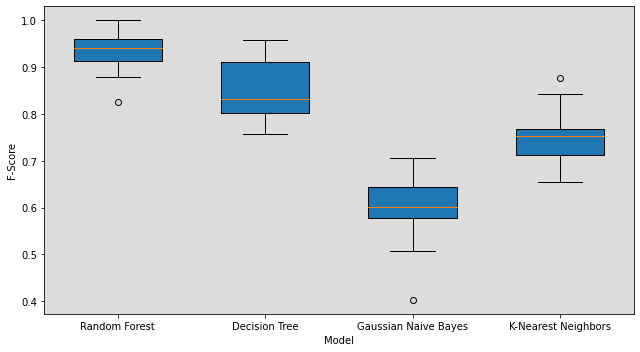

In [7]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold

# What we will do here is use stratified 10-fold cross validation for several
# datasets and plot the box plots of scores for each of the model.

names = ["Random Forest", "Decision Tree", "Gaussian Naive Bayes", "K-Nearest Neighbors"]
models = [RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier()]

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(111)
ax.set_facecolor('gainsboro')

skf = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
for i, name, model in zip(range(0, 5), names, models):
    scores = cross_val_score(model, pivoted.drop(columns=['Species']), pivoted['Species'],
                             scoring='f1_weighted', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i], vert=True,
               widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
ax.set_ylabel("F-Score")
ax.set_xlabel("Model")
plt.tight_layout()